## Questão 1

## Questão 2: Perceptron Backpropagation 

## Problema

Implemente uma rede perceptron de múltiplas camadas treinando-a com os seguinte algoritmos
    
  __a)__ algoritmo da retropropagação em modo estocástico usando a regra delta
    
  __b)__ algoritmo da retropropagação em modo por lote usando a regra delta
   
  __c)__ algoritmo da retropropagação usando a regra delta com termo do momento
    
    
## Características do dados

//TODO

## Geração atomática de dados

//TODO

In [1]:
import statistics as st
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from misc import plots

## Funções de Ativação

Foram implementadas funções básicas de ativação para serem opções no uso na rede.

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def degrau(x, derivative=False):
    if derivative:
        np.where(x>0.5,1,1)
    return np.where(x>0.5,1,0)

def step(x,derivative=False):
    if derivative:
        return np.where(x>0,1,1)
    return np.where(x>0,1,0)

## Função de Custo

In [3]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

In [24]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

In [23]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

## Função Suporte

In [26]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

In [27]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

In [43]:
same = lambda x: x
# tupla(x,limit)
threshold = lambda x: np.where(x[0]>x[1], 1, 0)

## Plotagem dos erros

In [4]:
def plot_error(data, title=""):
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("errors")
    plt.plot(data)
    plt.show()

## Classe Layer

A classe Layer representa uma layer da rede guardando a entrada da camada, pesos, biases, função de ativação e saída da camada.

### Parâmetros

- __input_dim__: dimensão dos dados de entrada da camada
- ___units___: quantidade de neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede

### Atributos

- __input__: dados de entrada da camada
- __weights__: matriz todos os pesos de todos os neutônios da camada
- __biases__: vetor com os valores dos bias de todos os neurônios da camada
- __activation__: função de ativação que será utilizada nos neurônios da rede
- __activ_out__: guarda os valores resultantes da função de ativação



In [48]:
class Layer:
    def __init__(self, input_dim, output_dim, activation=step, use_bias=True):
        self.input = None
        self.weights = np.random.randn(output_dim, input_dim)
        self.bias = np.random.randn(1, output_dim)
        self.activation = activation
        self._activ_inp, self._activ_out = None, None
        self.input_dim = input_dim
        self.use_bias = use_bias
        self.dweights, self.dbias = None, None
        self._dweights, self._dbias, self._prev_dweights = None, None, 0.0

## Classe NeuralNetwork

A classe representa a Rede Neural, na caso o Perceptron.

### Atributos

- __layers__: conjunto de layers da rede


In [60]:
class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, momentum=0.0):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = learning_rate
        self.momentum = momentum
    
    def fit(self, X=None, Y=None, epochs=1, batch_size=None, verbose=False):
        '''
            Função de treinamento
            Parâmetros:
                X - entradas
                Y - saídas esperadas
                epochs - quantidade de épocas de treinamento
                verbose - passos para verificação da época
        '''
        batch_size = X.shape[0] if batch_size is None else batch_size
        n_batches = X.shape[0] // batch_size
        
        for epoch in range(epochs+1):
            for batch in range(n_batches):
                offset = batch_size * batch
                X_batch, Y_batch = X[offset:offset+batch_size], Y[offset:offset+batch_size]
                y_pred = self.__feedforward(X)
                self.__backpropagation(Y, y_pred)
            
            if epoch % verbose == 0:
                print('Epoch: {}'.format(epoch))
    
    def add_layer(self, layer):
        '''
            Método para adição de layers ao modelo
            Parâmetros:
                layer - Layer a se adicionada ao modelo
        '''
        self.layers.append(layer)
    
    def __feedforward(self, x):
        '''
            Método de Feedforward - Efetua a multiplicação das entradas pelos pesos, soma ao bias, aplica função de ativação
            Parâmetros:
                x - dados de entrada
        '''
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.bias
            current_layer._activ_inp = y
            current_layer._activ_out = next_layer.input = current_layer.activation(y)
        return self.layers[-1]._activ_out
    
    def prediction(self, x):
        '''
            Método de Predição - Gera um conjunto de valores resultante do processo de FeedForward nos para os dados de entrada
            Parâmetros:
                x - dados de entrada
        '''
        y_pred = []
        
        for data in x:
            pred = self.__feedforward(data)

            for p in pred:
                pred = p
                break
    
            y_pred.append(pred)
            
        return np.array(y_pred)
    
    def predict(self, X, verbose=False):
        return self.__feedforward(X)
    
    def evaluate(self, y_pred, y, func=same, dtype=int):
        '''
            Método Evaluate - Verifica a accuracy da rede
            Parâmetros:
                y_pred - resultado do processo de FeedForward sobre os dados de entrada
                dtype - tipo dos dados
        '''
        score = 0
        total = 100.0/y.shape[0]
        y_pred = y_pred.astype(dtype)
        y = y.astype(dtype)

        for y_i, y_pred_i in zip(y,y_pred):
            y_pred_i = func(y_pred_i)
            if np.array_equal(y_i,y_pred_i):
                score+=1
        return score*total

    def __backpropagation(self, y, y_pred):
            last_delta = self.cost_func(y, y_pred, derivative=True)
            for layer in reversed(self.layers):
                dactivation = layer.activation(layer._activ_inp, derivative=True)*last_delta
                last_delta = np.dot(dactivation, layer.weights)
                layer.dweights = np.dot(dactivation.T, layer.input)
                layer.dbias = 1.0*dactivation.sum(axis=0, keepdims=True)

            for layer in reversed(self.layers):
                layer._prev_dweights = -self.learning_rate*layer.dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.bias - self.learning_rate*layer.dbias

## Execução

__1__ - A rede é inicializada

__2__ - Os dados de entrada e saida são obtidos

__3__ - Treinamento é feito com 80% dos dados e o Teste com os 20% restantes

__4__ - Accuracy da rede é verificada

## Arquitetura Usada

//TODO

## Parâmetros utilizados

//TODO

In [7]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q2/data_x_2.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q2/data_y_2.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

## 2 a) Treinamento Estocástico

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Épocas: 100


In [39]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=100, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

ValueError: shapes (1,1) and (8,8) not aligned: 1 (dim 1) != 8 (dim 0)

## 2 b) Treinamento com Batch

### Arquitetura

- __Parâmentros__: 
 - Learning Rate: 0.001
 - Layers: 2

- __Layer1__:
 - Dimensão de Entrada: 3
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Layer2__:
 - Dimensão de Entrada: 8
 - Dimensão de Saída: 8
 - Função de Ativação: Step

- __Treinamento__:
 - Batch: 5
 - Épocas: 200

epoch:    0/200
error: 0.0
epoch:   50/200
error: 0.0
epoch:  100/200
error: 0.0
epoch:  150/200
error: 0.0
epoch:  200/200
error: 0.0


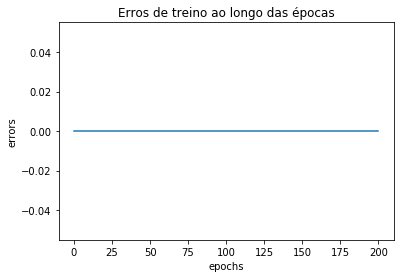

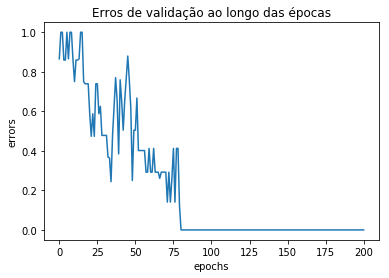

1.0


In [9]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, batch_size=5, epochs=200, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

## 2 c)

// TODO

epoch:    0/100
error: 0.0
epoch:   50/100
error: 0.0
epoch:  100/100
error: 0.0


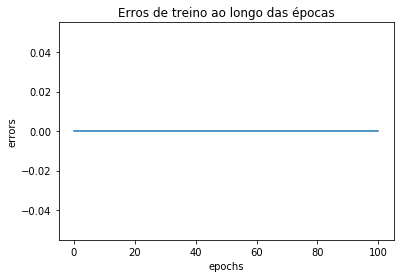

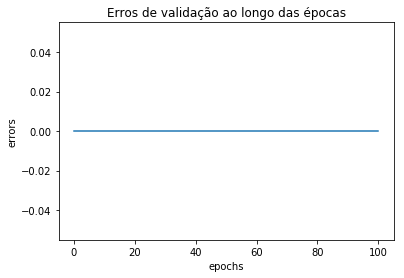

1.0


In [10]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=y.shape[1], activation=step))
nn.add_layer(Layer(input_dim=8, output_dim=8, activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid, y_valid, epochs=100, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred.round())

print(acc)

# Questão 3 - Convergência dos Algoritmos

## Problema

Usando algoritmos implementados na questão 2, aproxime as funções abaixo. Compare os resultados com as curvas exatas, para o caso dos itens b e c e apresente para cada caso a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Faça uma análise comparativa sobre a convergência de cada um dos algoritmos.

  __a)__ Função lógica XOR
  
  __b)__ f(x) = sen(pi*x) / pi*x
  
## 3 a)

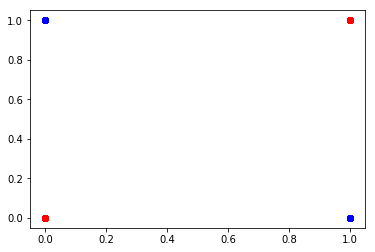

In [11]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q3/data_x_3a.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q3/data_y_3a.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

for index, y_i in enumerate(y):
    if y_i == 1:
        plt.plot(x[index][0], x[index][1], 'bo')
    else:
        plt.plot(x[index][0], x[index][1], 'ro')

plt.show()

### Estocástico

epoch:    0/300
error: 1.0
epoch:   50/300
error: 0.0
epoch:  100/300
error: 0.0
epoch:  150/300
error: 0.0
epoch:  200/300
error: 0.0
epoch:  250/300
error: 0.0
epoch:  300/300
error: 0.0


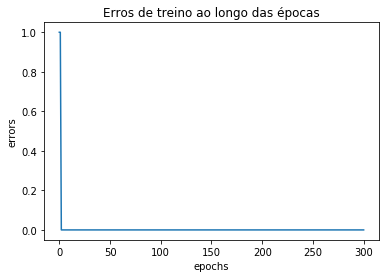

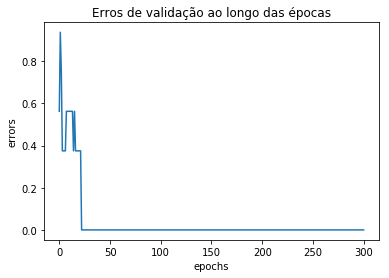

1.0


In [12]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, epochs=300, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Batch

epoch:    0/800
error: 0.0
epoch:  200/800
error: 0.0
epoch:  400/800
error: 0.0
epoch:  600/800
error: 0.0
epoch:  800/800
error: 0.0


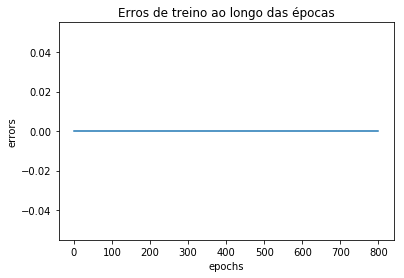

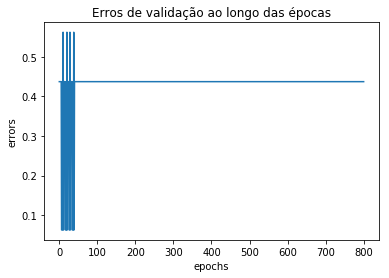

0.5625


In [13]:
nn = NeuralNetwork(learning_rate=0.05)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=5 ,epochs=800, verbose=200)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

### Momento

// TODO

epoch:    0/300
error: 0.0
epoch:   50/300
error: 0.0
epoch:  100/300
error: 0.0
epoch:  150/300
error: 0.0
epoch:  200/300
error: 0.0
epoch:  250/300
error: 0.0
epoch:  300/300
error: 0.0


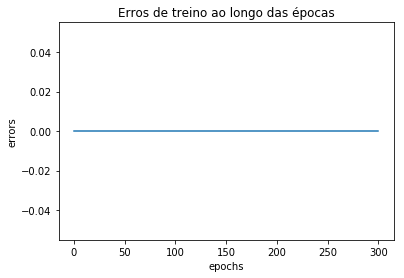

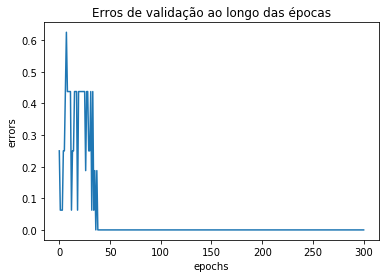

1.0


In [14]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=2, activation=sigmoid))
nn.add_layer(Layer(input_dim=2, output_dim=y.shape[1], activation=step))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, epochs=300, verbose=50)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)
acc = accuracy_score(y_valid, y_pred)

print(acc)

## 3 b)

// TODO

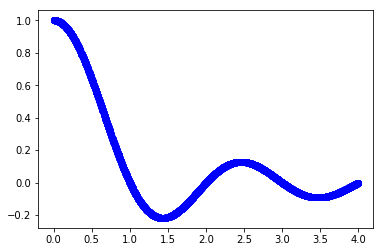

In [15]:
# Leitura dos dados de treinamento e validação

x = []
y = []

# leitura dos dados
for line in open('data/Q3/data_x_3b.txt', 'r').readlines():
    x.append([float(num) for num in line.split(',')])

for line in open('data/Q3/data_y_3b.txt', 'r').readlines():
    y.append([float(num) for num in line.split(',')])

# dados de treino
x = np.array(x[:int(len(x) * 0.8)])
y = np.array(y[:int(len(y) * 0.8)])

# dados de validação
x_valid = np.array(x[int(len(x) * 0.8):])
y_valid = np.array(y[int(len(y) * 0.8):])

plt.plot(x, y, 'bo')
plt.show()

### Estocástico

epoch:    0/500
error: 0.020776364870429095
epoch:   50/500
error: -0.0024289499197174234
epoch:  100/500
error: -0.002029042804724379
epoch:  150/500
error: -0.0018245995968022288
epoch:  200/500
error: -0.0015191370415558736
epoch:  250/500
error: -0.0012006383871386583
epoch:  300/500
error: -0.0009069056195207814
epoch:  350/500
error: -0.0007572641941915904
epoch:  400/500
error: -0.0007679745125110382
epoch:  450/500
error: -0.0008458452193407656
epoch:  500/500
error: -0.0007231667784740603


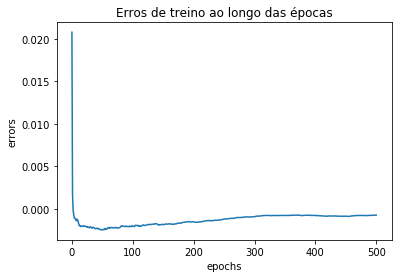

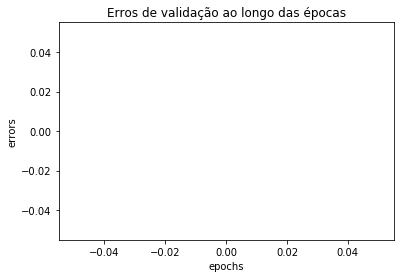

0.0


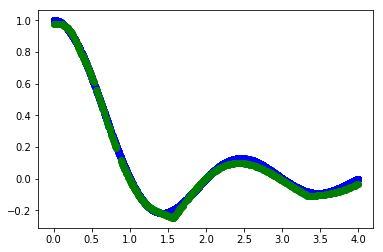

In [16]:
nn = NeuralNetwork(learning_rate=0.001)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=20, activation=relu))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=1, epochs=500, verbose=50, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

## Batch

In [17]:
nn = NeuralNetwork(learning_rate=0.01)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=4, activation=tanh))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=4, activation=relu))
nn.add_layer(Layer(input_dim=4, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=10, epochs=1000, verbose=100, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

epoch:    0/1000
error: 0.020635879988220536
epoch:  100/1000
error: -0.012391475646024884


KeyboardInterrupt: 

## Momento

epoch:    0/100
error: -0.021307394428886406
epoch:   20/100
error: 3.1590261377112405e-05
epoch:   40/100
error: -5.617975709859557e-06
epoch:   60/100
error: 9.945609301779956e-05
epoch:   80/100
error: 2.929960264685949e-07
epoch:  100/100
error: 8.537872118144496e-05


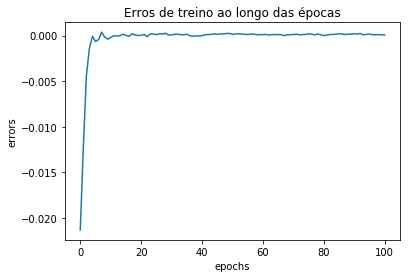

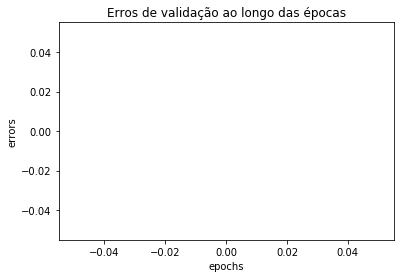

0.0


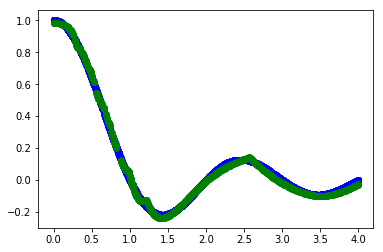

In [18]:
nn = NeuralNetwork(cost_func=mse, learning_rate=0.001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=20, activation=relu))
nn.add_layer(Layer(input_dim=20, output_dim=y.shape[1], activation=tanh))

# treinamento
errors_train, errors_valid = nn.fit(x, y, x_valid=x_valid, y_valid=y_valid, batch_size=1, epochs=100, verbose=20, backpropagation=True, accuracy=False)

plot_error(errors_train, "Erros de treino ao longo das épocas")
plot_error(errors_valid, "Erros de validação ao longo das épocas")

# calculo do erro de predição
y_pred = nn.prediction(x_valid)

check = 0
for valid, pred in zip(y_valid, y_pred): 
    #print(valid, pred)
    
    if valid[0] == pred[0]:
        check += 1
        
print(check / y_valid.shape[0])

plt.plot(x, y, 'bo')
plt.plot(x_valid, y_pred, 'go')
plt.show()

# Questão 4 - Classificação do Circulo

## Problema

Considere um problema de classificação de padrões constituído de oito padrões. A distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto de treinamento e um conjunto de validação. Treine uma rede perceptron para classificar os padrões associados a cada uma das classes. Verifique o desempenho do classificador usando o conjunto de validação e calculando a matriz de confusão.

## Leitura dos dados

In [90]:
# # Leitura dos dados de treinamento e validação

# x = []
# y = []

# # leitura dos dados
# for line in open('data/Q4/data_x_4.txt', 'r').readlines():
#     x.append([float(num) for num in line.split(',')])

# for line in open('data/Q4/data_y_4.txt', 'r').readlines():
#     y.append([float(num) for num in line.split(',')])

# # dados de treino
# x = np.array(x[:int(len(x) * 0.8)])
# y = np.array(y[:int(len(y) * 0.8)])

# # dados de validação
# x_valid = np.array(x[int(len(x) * 0.8):])
# y_valid = np.array(y[int(len(y) * 0.8):])

# colors = {0:'black', 1:'red', 2:'blue', 3:'green', 4:'orange', 5:'purple', 6:'hotpink', 7:'yellow'}

# plt.figure(figsize=(5,5))
# plt.scatter(x[:,0], x[:,1], s = 3, c=[colors[yp] for yp in y])
# plt.axis('equal')
# plt.show()

x = np.loadtxt('data/Q4/data_x_4.txt', delimiter=',')
y = np.loadtxt('data/Q4/data_y_4.txt', delimiter=',').reshape(-1,1)

from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse=False)
y_oh = onehot.fit_transform(y)

## Modelo

### Arquitetura
- Taxa de aprendizagem: 0.01
- momentum: 0.9
- Camadas Ocultas: 2
- Função de ativação: linear
- Função de custo: negative log likelihood

In [63]:
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=linear))
nn.add_layer(Layer(input_dim=20, output_dim=y_oh.shape[1], activation=linear))

# treinamento
nn.fit(X=x, Y=y_oh, epochs=10000, verbose=500)

# prediction
y_pred = nn.predict(x).argmax(axis=1)
accuracy_score(y, y_pred)
# errors_train, errors_valid = nn.fit(x, y_oh, x_valid=x_valid, y_valid=y_valid, batch_size=10, epochs=1000, verbose=100, backpropagation=True, accuracy=False)

# plot_error(errors_train, "Erros de treino ao longo das épocas")
# plot_error(errors_valid, "Erros de validação ao longo das épocas")

Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
Epoch: 3000
Epoch: 3500
Epoch: 4000
Epoch: 4500
Epoch: 5000
Epoch: 5500
Epoch: 6000
Epoch: 6500
Epoch: 7000
Epoch: 7500
Epoch: 8000
Epoch: 8500
Epoch: 9000
Epoch: 9500
Epoch: 10000


0.99491676197737955

# Questão 5

## Modelo

### Arquitetura

- Parâmetros:
    - Taxa de aprendizagem: 0.0001
    - Camadas: 4
- Camada 1:
    - Dimensão de Entrada: 3
    - Dimensão de Saída: 8
    - Função de Ativação: Step
- Layer2:
    - Dimensão de Entrada: 8
    - Dimensão de Saída: 8
    - Função de Ativação: Step
- Treinamento:
    - Épocas: 100
- Taxa de aprendizagem: 0.0001
- momentum: 0.9
- Camadas Ocultas: 4
- Função de ativação: tanh
- Função de custo: mse

Epoch: 0
Epoch: 300
Epoch: 600
Epoch: 900
Epoch: 1200
Epoch: 1500
Epoch: 1800
Epoch: 2100
Epoch: 2400
Epoch: 2700
Epoch: 3000


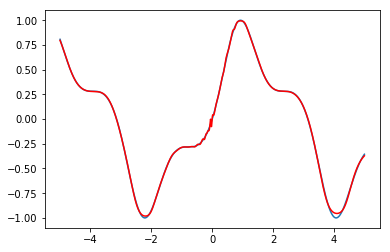

In [85]:
# Gerando entrada dos dados
x = np.linspace(-5, 5, 1000).reshape(-1, 1)
y = np.sin(x + np.sin(x)**2).reshape(-1, 1)

# Instanciando o modelo
nn = NeuralNetwork(cost_func=mse, learning_rate=0.0001, momentum=0.9)
nn.add_layer(Layer(input_dim=x.shape[1], output_dim=20, activation=tanh))
nn.add_layer(Layer(input_dim=20, output_dim=30, activation=tanh))
nn.add_layer(Layer(input_dim=30, output_dim=30, activation=tanh))
nn.add_layer(Layer(input_dim=30, output_dim=y.shape[1], activation=tanh))

# Treinando a rede
nn.fit(x, y, epochs=3000, verbose=300)

# Prediction
y_pred = nn.predict(x)
plt.plot(x, y)
plt.plot(x, y_pred, c='red')
plt.show()